# Initial Investigation on CLIP

This is a self-contained notebook that shows how to download and run CLIP models, to run linear probing on a new dataset, in order to investigate the zero-shot performance capabilities of each pre-trained model.  

## Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
#!pip install scikit-learn-intelex
! pip install optuna
! pip install ftfy regex tqdm optuna
! pip install git+https://github.com/ridvansalihkuzu/CLIP.git

In [2]:
import os
import clip
import torch

import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from collections import Counter

#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from optuna.samplers import TPESampler

%matplotlib inline

## Loading the Model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
available_models=clip.available_models()
available_models

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
selected_model_name=available_models[-2]
model, transform = clip.load(selected_model_name,device) 
#model, transform = clip.load('logs/selected_0.0001_-2_ARC_MLP_HEAD_model.pth.tar',device)

## Loading the Data

Training and test data are loaded and their distribution over classes is observed below:

In [5]:
print("[INFO] Loading the training and test dataset...")
train_data_root='data/coco_crops_few_shot/train'
test_data_root='data/coco_crops_few_shot/test'

train_dataset = ImageFolder(root=train_data_root,transform=transform)
test_dataset = ImageFolder(root=test_data_root,transform=transform)
print("[INFO] Training dataset contains {} samples.".format(len(train_dataset)))
print("[INFO] Test dataset contains {} samples.".format(len(test_dataset)))

[INFO] Loading the training and test dataset...
[INFO] Training dataset contains 234 samples.
[INFO] Test dataset contains 503 samples.


In [6]:
def get_class_distribution(dataset_obj):
    '''
        THIS FUNCTION CALCULATES THE DISTRIBUTION OF SAMPLES FOR EACH CLASS IN A GIVEN DATASET
        :param dataset_obj: dataset object
        :return: returns key-value pairs of { class name , number of samples } 
    '''
    counter=Counter([label for _, label in dataset_obj]) 
    count_dict = {k[0]:v[1] for k,v in zip(dataset_obj.class_to_idx.items(),counter.items())}
            
    return count_dict

In [7]:
training_dist=get_class_distribution(train_dataset)
test_dist=get_class_distribution(test_dataset)
print("INFO: Distribution of classes in training dataset: \n:", training_dist)
print("INFO: Distribution of classes in test dataset: \n:", test_dist)

INFO: Distribution of classes in training dataset: 
: {'airplane': 38, 'bicycle': 21, 'boat': 20, 'bus': 40, 'car': 19, 'motorcycle': 30, 'train': 44, 'truck': 22}
INFO: Distribution of classes in test dataset: 
: {'airplane': 60, 'bicycle': 46, 'boat': 79, 'bus': 69, 'car': 47, 'motorcycle': 54, 'train': 67, 'truck': 81}


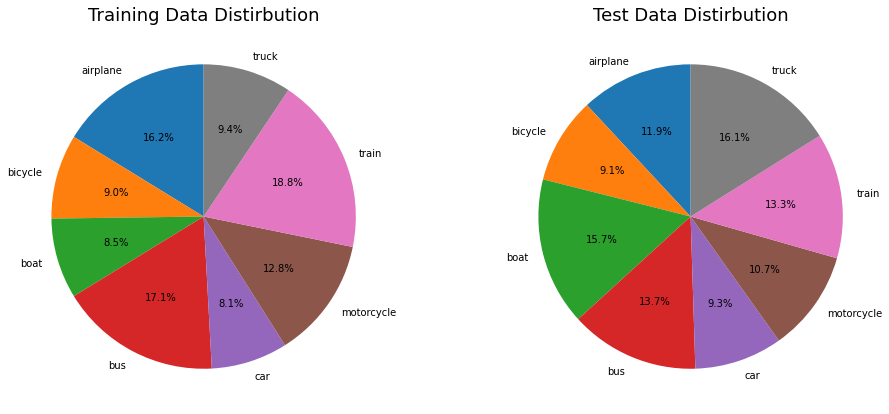

In [8]:

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,7))
ax1.pie(list(training_dist.values()), labels=test_dataset.classes, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.set_title('Training Data Distirbution',fontsize=18)
ax2.pie(list(test_dist.values()), labels=test_dataset.classes, autopct='%1.1f%%', shadow=False, startangle=90)
ax2.set_title('Test Data Distirbution',fontsize=18)
plt.show()
#fig.savefig('data_distirbution.jpg')

## Extracting Features

By using `encode_image` function of the CLIP model, the train and test features are extracted as shown below:

In [9]:
def get_features(dataset, model, batch_size=32):
    '''
        THIS FUNCTION EXTRACTS THE FEATURES OF GIVEN IMAGES BY USING IMAGE_ENCODER METHOD OF THE GIVEN MODEL
        :param dataset: dataset object in ImageFolder type
        :param model: CLIP model to be exploited for feature extraction
        :param batch_size: the size of each batches in data reading
        :return: returns the tuple of (extracted features, labels)
    '''

    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=32)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [10]:
# Extract the image features
train_features, y_train = get_features(train_dataset,model)
test_features, y_test = get_features(test_dataset,model)



100%|██████████| 16/16 [02:28<00:00,  9.29s/it]


## Training Linear Probe Models

Here, `LogisticRegression` based linear probe training has been conducted with stratified cross validation. Later, the final model has been evaluated on the test set. For training and evaluation, the reason behind choosing the logistic regression is to be inline with the zero-shot learning comparison of the original CLIP paper (considering Figure 6). 

By depending on `optuna` library, Bayesian hyper-parameter search techniques have been preferred, an objective function has searched the best `C` value (regularization strength) to maximize the weighted F1 score in the cross-validation phase. 

In [11]:
def objective(trial,features, labels):
    print(f"INFO: Trial number: {trial.number}\n")

    reg_strength = trial.suggest_float("reg_strength", 0.005, 1, step=0.005)
    
    classifier = LogisticRegression(random_state=42, C=reg_strength, max_iter=1000, verbose=0,class_weight='balanced',n_jobs=-1)
    cv_results = cross_validate(classifier, features, labels, cv=5, scoring=('f1_weighted'))
    mean_f1=np.mean(cv_results['test_score'])
    
    return mean_f1


In [12]:
study = optuna.create_study(sampler=TPESampler(), direction='maximize')
study.optimize(lambda trial: objective(trial, train_features, y_train), n_trials=20)
        
    

[I 2022-06-21 02:50:18,220] A new study created in memory with name: no-name-7effbe0a-c100-4d6b-9d24-eb3f538775ac


INFO: Trial number: 0



[I 2022-06-21 02:50:26,417] Trial 0 finished with value: 0.926649058943718 and parameters: {'reg_strength': 0.33}. Best is trial 0 with value: 0.926649058943718.


INFO: Trial number: 1



[I 2022-06-21 02:50:28,725] Trial 1 finished with value: 0.926649058943718 and parameters: {'reg_strength': 0.665}. Best is trial 0 with value: 0.926649058943718.


INFO: Trial number: 2



[I 2022-06-21 02:50:31,113] Trial 2 finished with value: 0.926649058943718 and parameters: {'reg_strength': 0.5650000000000001}. Best is trial 0 with value: 0.926649058943718.


INFO: Trial number: 3



[I 2022-06-21 02:50:33,422] Trial 3 finished with value: 0.9428002324231306 and parameters: {'reg_strength': 1.0}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 4



[I 2022-06-21 02:50:35,880] Trial 4 finished with value: 0.9386561634480228 and parameters: {'reg_strength': 0.8350000000000001}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 5



[I 2022-06-21 02:50:38,131] Trial 5 finished with value: 0.9116993849637343 and parameters: {'reg_strength': 0.17500000000000002}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 6



[I 2022-06-21 02:50:40,435] Trial 6 finished with value: 0.9386561634480228 and parameters: {'reg_strength': 0.9500000000000001}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 7



[I 2022-06-21 02:50:42,681] Trial 7 finished with value: 0.926649058943718 and parameters: {'reg_strength': 0.325}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 8



[I 2022-06-21 02:50:45,009] Trial 8 finished with value: 0.921577804416622 and parameters: {'reg_strength': 0.225}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 9



[I 2022-06-21 02:50:47,269] Trial 9 finished with value: 0.9116993849637343 and parameters: {'reg_strength': 0.17}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 10



[I 2022-06-21 02:50:49,626] Trial 10 finished with value: 0.9428002324231306 and parameters: {'reg_strength': 1.0}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 11



[I 2022-06-21 02:50:52,010] Trial 11 finished with value: 0.9428002324231306 and parameters: {'reg_strength': 0.99}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 12



[I 2022-06-21 02:50:54,287] Trial 12 finished with value: 0.926649058943718 and parameters: {'reg_strength': 0.785}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 13



[I 2022-06-21 02:50:56,800] Trial 13 finished with value: 0.926649058943718 and parameters: {'reg_strength': 0.8150000000000001}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 14



[I 2022-06-21 02:50:59,177] Trial 14 finished with value: 0.926649058943718 and parameters: {'reg_strength': 0.65}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 15



[I 2022-06-21 02:51:01,493] Trial 15 finished with value: 0.9386561634480228 and parameters: {'reg_strength': 0.915}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 16



[I 2022-06-21 02:51:04,075] Trial 16 finished with value: 0.926649058943718 and parameters: {'reg_strength': 0.46}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 17



[I 2022-06-21 02:51:06,825] Trial 17 finished with value: 0.926649058943718 and parameters: {'reg_strength': 0.72}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 18



[I 2022-06-21 02:51:09,587] Trial 18 finished with value: 0.9386561634480228 and parameters: {'reg_strength': 0.91}. Best is trial 3 with value: 0.9428002324231306.


INFO: Trial number: 19



[I 2022-06-21 02:51:12,212] Trial 19 finished with value: 0.8996041175921347 and parameters: {'reg_strength': 0.02}. Best is trial 3 with value: 0.9428002324231306.


## Testing Models and Observing Performance Metrics

Here, after finding the best regularization strength (`C`) parameter of the `LogisticRegression`, the model has been re-fitted on the entire training data. 

Later, the precision, recall and F1-scores have been calculated on the test set. The main reason to choose those metrics was that: standard accuracy might be a misleading metrics in case of having an unbalanced dataset.

In [13]:
opt_reg_strength=study.best_trial.params['reg_strength'] 
classifier = LogisticRegression(random_state=0, C=opt_reg_strength, max_iter=1000, verbose=1,class_weight='balanced',n_jobs=-1)
classifier.fit(train_features, y_train)
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         6152     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86589D+02    |proj g|=  1.67054D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 6152     32     39      1     0     0   3.230D-04   3.019D+02
  F =   301.90478201966965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=0, verbose=1)

In [14]:
# Evaluate using the logistic regression classifier
y_pred = classifier.predict(test_features)

report=classification_report(y_test, y_pred, target_names=test_dataset.classes)
print(report)


              precision    recall  f1-score   support

    airplane       0.97      1.00      0.98        60
     bicycle       0.96      1.00      0.98        46
        boat       0.99      0.95      0.97        79
         bus       0.93      0.94      0.94        69
         car       0.74      0.72      0.73        47
  motorcycle       0.96      0.98      0.97        54
       train       0.99      1.00      0.99        67
       truck       0.83      0.80      0.82        81

    accuracy                           0.92       503
   macro avg       0.92      0.92      0.92       503
weighted avg       0.92      0.92      0.92       503



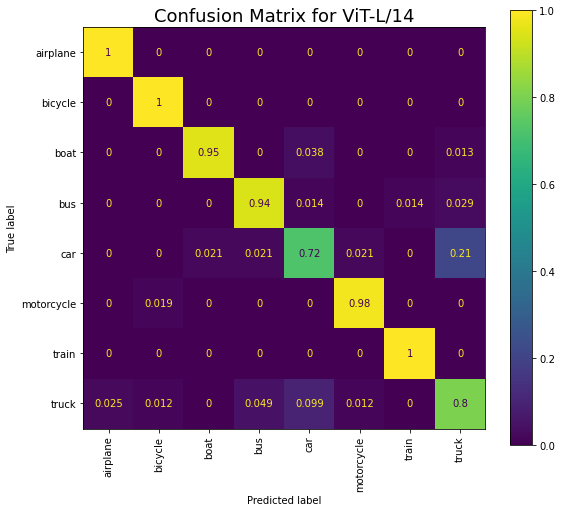

In [19]:
fig, ax = plt.subplots(figsize=(9,8))
cm = confusion_matrix(y_test, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
ax.set_title("Confusion Matrix for {}".format(selected_model_name),fontsize=18)
disp.plot(xticks_rotation='vertical',ax=ax)
#fig.savefig('confusion_matrix.jpg')

## Comparing Each Pretrained Model Seperately

In the below cell,  the linear probe training and evaluation can be executed for all available pretrained models of CLIP. 

If you face the dying kernel problem in Jupyter notebook due to the heavy dynamic memory allocations for some of the pre-trained models, as an alternative to the code block below, the entire comparison can be run in the following function: [01_b_clip_linear_probe_tuning.py](https://github.com/ridvansalihkuzu/CLIP/blob/main/01_b_clip_linear_probe_tuning.py)

In [ ]:
for model_name in available_models:
    model, transform = clip.load(model_name,device)
    
    train_dataset = ImageFolder(root=train_data_root,transform=transform)
    test_dataset = ImageFolder(root=test_data_root,transform=transform)
    
    train_features, y_train = get_features(train_dataset,model)
    test_features, y_test = get_features(test_dataset,model)
    
    study = optuna.create_study(sampler=TPESampler(), direction='maximize')
    study.optimize(lambda trial: objective(trial, train_features, y_train), n_trials=20)
    
    opt_reg_strength=study.best_trial.params['reg_strength'] 
    classifier = LogisticRegression(random_state=0, C=opt_reg_strength, max_iter=1000, verbose=0,class_weight='balanced',n_jobs=-1)
    classifier.fit(train_features, y_train)
    
    y_pred = classifier.predict(test_features)
    report=classification_report(y_test, y_pred, target_names=test_dataset.classes,output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    #report_df.to_csv('classification_report_{}.csv'.format(model_name), index = False)
    
    fig, ax = plt.subplots(figsize=(9,8))
    ax.set_title("Confusion Matrix for {}".format(model_name),fontsize=18)
    cm = confusion_matrix(y_test, y_pred,normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
    disp.plot(xticks_rotation='vertical',ax=ax)
    #fig.savefig('confusion_matrix_{}.jpg'.format(model_name))
    
   